# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

<font size=4><b>Описание данных </font></b>

<b>Технологический процесс</b>
- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- `Xanthate` — ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

<b>Параметры этапов</b>
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

<b>Наименование признаков</b>
    
    Наименование признаков должно быть такое:
    [этап].[тип_параметра].[название_параметра]
    Пример: rougher.input.feed_ag
Возможные значения для блока [этап]:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики
Возможные значения для блока [тип_параметра]:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

## Подготовка данных

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

### Загрузим наши датасеты и изучим их.

In [2]:
df_train=pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test=pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full=pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
#обучающая выборка
df_train.sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
6453,2017-03-29 01:59:59,6.439484,10.337747,10.368218,44.185407,66.176489,10.154185,3.081353,10.234472,3.303333,...,25.012694,-400.869291,22.981782,-400.221335,29.855102,-449.937652,23.983982,-449.973349,24.997469,-500.290213
1294,2016-03-15 15:00:00,4.891288,10.144035,NaN,43.864960,51.142376,11.737320,2.362321,10.940334,3.537791,...,12.079583,-499.235259,12.070643,-500.609918,12.005231,-499.813593,9.929209,-500.460163,19.982613,-499.968516
7853,2017-06-08 15:59:59,3.203948,7.685245,6.125540,35.113460,65.275308,9.115348,3.494184,8.999017,3.352367,...,15.062805,-499.764871,9.910267,-380.013862,15.020912,-500.085743,9.990688,-499.919227,14.988442,-500.294811
11521,2018-04-11 12:59:59,3.990251,10.318484,7.990059,48.031595,75.942548,9.137777,1.817899,7.512217,1.698492,...,22.974744,-500.300473,15.993021,-499.829856,17.994708,-500.281021,12.025567,-499.836729,13.019217,-501.258366
2101,2016-05-05 09:59:59,4.922136,10.921704,9.840690,45.387092,56.484533,7.794478,2.177571,12.898558,4.053098,...,13.994973,-499.167778,12.007341,-499.559576,11.024725,-499.172166,9.945266,-499.876769,19.985860,-499.434755
13268,2018-07-01 16:59:59,3.778201,12.018517,6.630570,45.132151,64.196943,10.724112,3.295329,8.145728,2.540952,...,25.023789,-500.323637,20.008901,-499.656440,17.956239,-499.901861,12.983529,-500.005920,12.986782,-499.772841
3245,2016-06-24 19:59:59,4.876003,9.989649,8.447113,44.663520,69.484108,8.129902,1.805347,11.313432,2.646701,...,15.967932,-498.496684,8.027520,-482.006475,15.991471,-496.255021,7.000942,-499.577076,24.960675,-498.018556
11506,2018-04-10 21:59:59,4.068076,10.617141,8.219554,47.324779,69.122733,9.749850,1.992082,7.169708,2.237453,...,23.021082,-500.649247,16.017843,-500.122132,18.017044,-500.143387,11.976511,-500.029029,13.006925,-500.535217
504,2016-02-07 12:00:00,5.067338,10.557382,0.515755,45.156734,36.777016,10.712052,1.240399,16.188759,2.194391,...,17.025506,-500.783983,16.002853,-500.768772,17.996364,-500.202848,16.024853,-499.515336,17.990359,-499.917621
10703,2018-03-01 20:59:59,5.648765,9.575525,7.665725,45.986914,78.450895,10.625504,1.577467,9.165919,1.811090,...,23.028989,-499.229568,14.952855,-500.296972,18.017754,-499.594700,12.014880,-499.936602,11.991718,-499.460876


In [4]:
#обучающая выборка
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
print('Строк, столбцов в обучающей выборке:', df_train.shape)
print('Количество пропусков в обучающей выборке:', df_train.duplicated().sum())

Строк, столбцов в обучающей выборке: (14149, 87)
Количество пропусков в обучающей выборке: 0


В обучающей выборке содержится 14149 строк и 87 столбцов, в некоторых столбцах есть пропуски, дубликатов в обучающем датасете нет. Все признаки, кроме столбца date, имеют тип данных `float64`.

In [6]:
#тестовая выборка
df_test.sample(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
1354,2016-11-07 03:59:59,160.688781,8.967334,7.534,0.890442,1600.585710,-499.016627,1599.623227,-500.316172,1600.674455,...,14.967238,-498.479750,12.956377,-498.539959,16.932982,-500.760946,13.994380,-500.373063,23.508093,-499.233848
1522,2016-11-14 12:59:59,230.589519,8.908316,7.400,0.902373,1599.940811,-499.843989,1596.625513,-499.749617,1600.065955,...,16.014030,-500.937231,13.991056,-501.570527,15.213491,-499.533809,13.992537,-500.139674,21.981926,-498.161503
2903,2017-09-16 19:59:59,162.636761,8.446800,7.290,1.200790,1600.807832,-500.045150,1603.381262,-499.525124,1601.500386,...,11.999614,-500.261586,9.050440,-399.571008,8.945573,-499.924937,6.961925,-500.031493,9.991248,-500.361291
4205,2017-11-13 20:59:59,182.710991,6.971323,6.810,2.489101,1596.611147,-500.316683,1599.287396,-508.914723,1587.806502,...,17.008659,-499.671514,10.031871,-499.694839,10.930412,-500.011765,8.983591,-500.342505,16.005085,-501.049943
2458,2016-12-24 16:59:59,159.835549,11.523891,7.005,1.444380,1699.338317,-499.969466,1701.447436,-499.651981,1697.633713,...,17.017385,-500.328932,14.897410,-499.033171,12.612152,-500.066229,12.014837,-500.458028,20.984473,-500.043076
4314,2017-11-18 10:59:59,231.632358,9.932195,6.570,3.890629,1601.938855,-499.476246,1598.263001,-482.306138,1528.593040,...,17.015718,-500.085954,14.898806,-499.916387,10.926903,-500.187676,9.007131,-500.069746,15.978064,-500.062972
3005,2017-09-21 01:59:59,120.481806,8.473056,7.070,1.436453,1401.155957,-499.936594,1402.148863,-500.444050,1398.307973,...,12.010566,-499.073573,8.970911,-399.833796,8.963417,-499.828178,6.917375,-500.193289,9.943677,-499.301456
2215,2016-12-14 08:59:59,178.649834,10.527035,7.560,1.502174,1608.106433,-500.968451,1596.290573,-500.080032,1600.223668,...,17.016434,-500.723246,15.032590,-498.940928,17.881399,-499.014118,11.984562,-499.680563,21.018969,-498.130637
861,2016-10-16 22:59:59,209.929831,20.030388,6.650,1.003994,1648.923169,-500.020046,1700.312602,-500.273389,1700.699141,...,20.032311,-500.393569,14.978120,-499.246776,8.804194,-500.901176,14.015530,-500.743487,16.979761,-499.879572
4258,2017-11-16 01:59:59,179.323869,8.011662,7.100,2.798026,1595.651816,-499.990576,1598.794799,-507.579980,1566.388527,...,17.029656,-500.348146,10.047170,-499.996690,10.963562,-499.485004,9.008059,-499.277339,15.996524,-501.119845


In [7]:
#тестовая выборка
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [8]:
print('Строк, столбцов в тестовой выборке:', df_test.shape)
print('Количество пропусков в тестовой выборке:', df_test.duplicated().sum())

Строк, столбцов в тестовой выборке: (5290, 53)
Количество пропусков в тестовой выборке: 0


В тестовой выборке 5290 строк и 53 столбца. В некоторых столбцах есть пропуски, дубликатов в тестовом датасете нет. Все признаки, кроме столбца date, имеют тип данных `float64`.

Также в тестовой выборке меньше столбцов, т.к. некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

In [9]:
#исходные данные
df_full.sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4862,2016-09-08 21:59:59,5.426128,8.441767,9.991697,46.908948,68.069296,11.821009,2.840910,9.833417,3.859317,...,7.993792,-499.005565,4.982876,-596.301991,8.309094,-598.624902,3.000605,-601.433745,19.990283,-600.210467
11349,2017-07-17 02:59:59,3.943884,11.307592,11.433789,45.271179,61.224268,7.357417,2.914770,11.281111,2.933470,...,22.032577,-499.586488,14.960289,-380.907013,18.030491,-499.448045,13.001837,-499.952618,14.984868,-499.320747
18745,2018-07-10 12:59:59,2.988501,11.796082,7.007810,46.758499,74.143633,10.362927,4.285993,8.477213,2.069370,...,24.972114,-500.915578,19.976682,-501.530175,18.015036,-500.708307,13.002405,-500.302093,12.995013,-500.117120
7790,2017-01-27 18:59:59,4.311087,8.657432,14.638681,42.055453,76.204744,11.216624,3.277021,9.484186,2.848851,...,20.945520,-500.187661,20.998018,-499.661024,23.014511,-500.266176,20.004534,-500.148412,25.001888,-600.046202
17968,2018-06-04 01:59:59,4.063730,11.767245,5.816548,44.661456,82.515083,6.406692,2.051820,8.743108,1.067801,...,29.924716,-500.043847,21.935435,-500.055980,24.979913,-499.689283,22.951320,-499.650478,24.979158,-500.815718
18156,2018-06-11 22:59:59,5.472369,8.887982,6.769234,45.354023,77.867938,5.451118,1.302801,2.451839,1.574064,...,30.036581,-493.092406,22.011604,-498.881062,25.004471,-497.930281,23.004864,-500.014398,24.991973,-497.764470
1121,2016-03-05 12:00:00,5.083276,12.071663,7.104515,39.942376,67.480828,10.042333,0.979425,17.331723,2.278023,...,13.962722,-399.069266,13.981140,-399.792815,11.919977,-399.926145,9.976364,-400.094659,24.033503,-399.764887
10906,2017-06-27 22:59:59,3.927248,10.994978,10.044905,45.409755,62.256185,8.100815,2.753104,10.483569,2.575788,...,18.022402,-500.447263,12.965083,-379.538579,18.030716,-500.096082,13.017405,-500.278215,15.006200,-500.250979
16601,2018-03-28 19:59:59,6.030254,10.006327,8.992531,44.576378,77.120180,12.706357,2.668171,7.616510,2.936097,...,22.989890,-500.358546,14.893834,-500.060784,17.967850,-500.308781,11.983343,-499.873804,13.004118,-499.939109
5741,2016-10-25 06:59:59,5.532580,9.831022,11.537392,45.469893,74.421582,9.597984,2.283684,9.589319,3.312520,...,20.015447,-500.392344,16.979797,-500.915513,16.978273,-500.803030,13.947284,-500.185081,25.017579,-500.995066


In [10]:
#исходные данные
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [11]:
print('Строк, столбцов в исходной выборке:', df_full.shape)
print('Количество пропусков в исходной выборке:', df_full.duplicated().sum())

Строк, столбцов в исходной выборке: (19439, 87)
Количество пропусков в исходной выборке: 0


### Расчет эффективности обогащения

Эффективность обогащения рассчитывается по формуле:

$
Recovery = \frac{C*(F-T)}{F*(C-T)}*100%
$

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Вычислим recovery на обучающей выборке для признака `rougher.output.recovery`

In [12]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [13]:
recovery = ((C*(F-T))/(F*(C-T)))*100
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery)

In [14]:
print('Показатель МАЕ составляет:', mae)

Показатель МАЕ составляет: 9.73512347450521e-15


Показатель МАЕ составляет 9,73, что является хорошим результатом, значит эффективность обогащения рассчитана корректно.

### Анализ признаков, недоступных в тестовой выборке

In [15]:
for column in list(df_train.columns):
    if column not in list(df_test.columns):
        print(column)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке на всех этапах отсутствуют выходные параметры продукта `(output)`: концентрация металлов `(concentrate)` и отвальные хвосты `(tail)` для металлов (Au, Ag, Pb) и солей (Sol). Эти данные не подойдут для тренировки модели, так как появляются во время или после измерения целевых признаков. Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации - `calculation`.

Данные колонки необходимо удалить из тренировочного датасета, за исключением столбцов `final.output.recovery` и `rougher.output.recovery`, т.к. они являются целевыми признаками.

### Предобработка данных

Удалим сразу лишние столбцы из обучающей выборки и выделим столбцы с целевыми признаками.

In [16]:
#сохраним отдельно целевые признаки
target_train = df_train[['final.output.recovery', 'rougher.output.recovery']]

In [17]:
#удаляем столбцы из обучающей выборки
for column in list(df_train.columns):
    if column not in list(df_test.columns):
        df_train.drop(column, axis=1, inplace=True)
        
df_train.shape

(14149, 53)

In [18]:
#снова добавим столбцы с целевыми признаками в обучающий датасет
df_train = df_train.join(target_train)

In [19]:
df_train.shape

(14149, 55)

Приведем все столбцы с датой к формату `datetime`.

In [20]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

In [21]:
#проиндексируем наши датасеты по дате
df_train= df_train.set_index('date')
df_test= df_test.set_index('date')
df_full = df_full.set_index('date')

Теперь заменим пропуски в датасетах на данные из соседних строк.

In [22]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')
target_train = target_train.fillna(method='ffill')

### Вывод по разделу

1. В обучающей выборке содержится 14149 строк и 87 столбцов, в некоторых столбцах есть пропуски, дубликатов в обучающем датасете нет. Все признаки, кроме столбца date, имеют тип данных float64.
2. В тестовой выборке 5290 строк и 53 столбца. В некоторых столбцах есть пропуски, дубликатов в тестовом датасете нет. Все признаки, кроме столбца date, имеют тип данных `float64`. Также в тестовой выборке меньше столбцов, т.к. некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
3. Эффективность обогащения в обучающей выборке рассчитана правильно, т.к. показатель МАЕ составил 9,73, что является хорошим результатом и говорит о корректности расчетов.
4. В тестовой выборке на всех этапах отсутствуют выходные параметры продукта (output): концентрация металлов (concentrate) и отвальные хвосты (tail) для металлов (Au, Ag, Pb) и солей (Sol). Эти данные не подойдут для тренировки модели, так как появляются во время или после измерения целевых признаков. Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации - calculation. Данные колонки были удалены из обучающего датасета, а столбцы `final.output.recovery` и `rougher.output.recovery` были назначены целевыми признаками.
5. При предобработке:
- столбцы с датой были приведены к формату `datetime`;
- пропуски в датасетах были заменены на данные из соседних строк.

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Построим гистограммы по изменению концентрации каждого металла (золото, серебро, свинец) на всех этапах очистки:
1. Исходное сырье;
2. Флотация;
3. Первичная обработка;
4. Финальный концентрат.

In [23]:
#создадим константы с данными по металлам
#золото
AU = df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au',
              'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
#серебро
AG = df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
              'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
#свинец
PB = df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
              'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

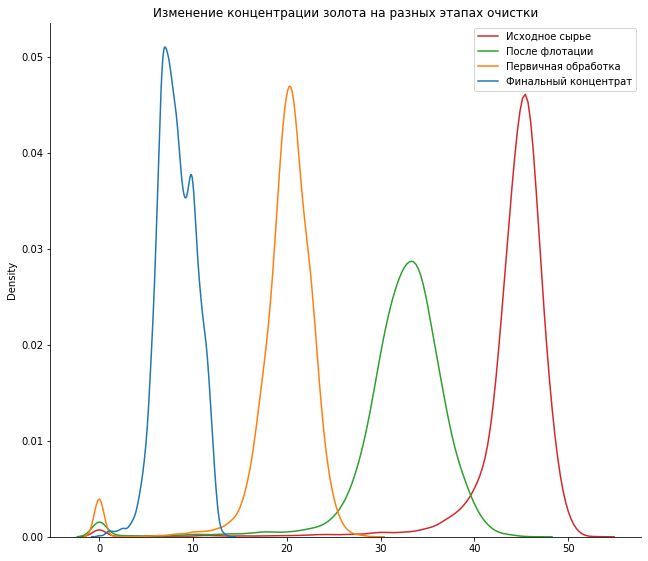

In [24]:
ax = sns.displot(AU, kind='kde', legend=False)
plt.legend(labels = ['Исходное сырье', 'После флотации', 'Первичная обработка', 'Финальный концентрат'])
plt.title('Изменение концентрации золота на разных этапах очистки')
ax.fig.set_figwidth(10)
ax.fig.set_figheight(8)
plt.show()

Как видно из гистограммы, после прохождения всех этапов очистки концентрация золота увеличивается.

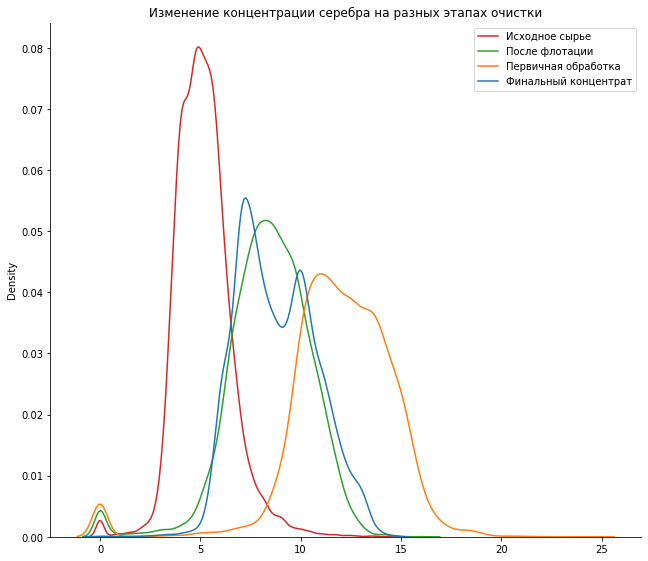

In [25]:
ax = sns.displot(AG, kind='kde', legend=False)
plt.legend(labels = ['Исходное сырье', 'После флотации', 'Первичная обработка', 'Финальный концентрат'])
plt.title('Изменение концентрации серебра на разных этапах очистки')
ax.fig.set_figwidth(10)
ax.fig.set_figheight(8)
plt.show()

Концентрация серебра после обработки, наоборот, уменьшилось.

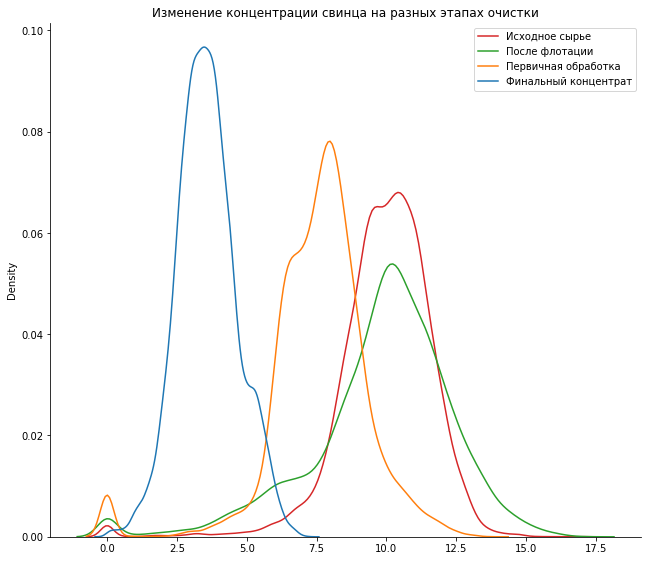

In [26]:
ax = sns.displot(PB, kind='kde', legend=False)
plt.legend(labels = ['Исходное сырье', 'После флотации', 'Первичная обработка', 'Финальный концентрат'])
plt.title('Изменение концентрации свинца на разных этапах очистки')
ax.fig.set_figwidth(10)
ax.fig.set_figheight(8)
plt.show()

Свинец показывает ту же тенденцию, что и золото и его концентрация после очистки увеличилась.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

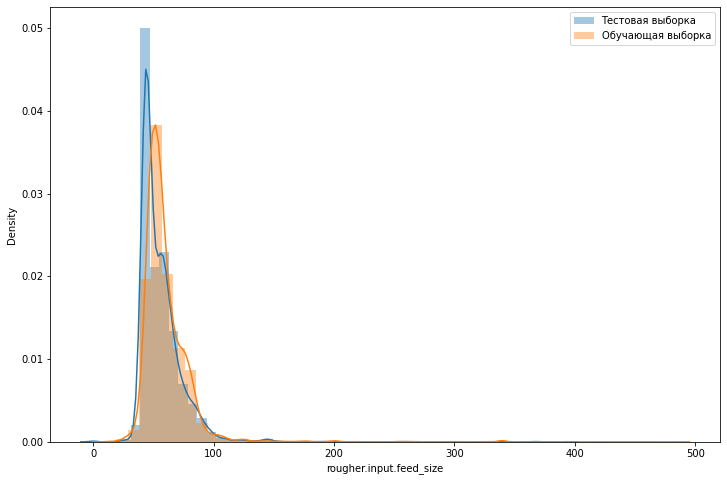

In [27]:
plt.figure(figsize=(12,8))
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка')
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка')
plt.legend()
plt.show()

Распределения на обучающей и тестовой выборке похожи, поэтому модель будет работать правильно.

### Исследование суммарной концентрации всех веществ на разных стадиях.

In [28]:
#исходное сырье
sum_feed = (df_full['rougher.input.feed_ag'] +
            df_full['rougher.input.feed_pb'] +
            df_full['rougher.input.feed_sol'] +
            df_full['rougher.input.feed_au'])

In [29]:
#флотация
sum_rougher = (df_full['rougher.output.concentrate_ag'] + 
               df_full['rougher.output.concentrate_pb'] + 
               df_full['rougher.output.concentrate_sol'] + 
               df_full['rougher.output.concentrate_au'])

In [30]:
#первичная очистка
sum_primary = (df_full['primary_cleaner.output.concentrate_ag'] + 
               df_full['primary_cleaner.output.concentrate_pb'] + 
               df_full['primary_cleaner.output.concentrate_sol'] + 
               df_full['primary_cleaner.output.concentrate_au'])

In [31]:
#финальная концентрация
sum_final = (df_full['final.output.concentrate_ag'] + 
             df_full['final.output.concentrate_pb'] + 
             df_full['final.output.concentrate_sol'] + 
             df_full['final.output.concentrate_au'])

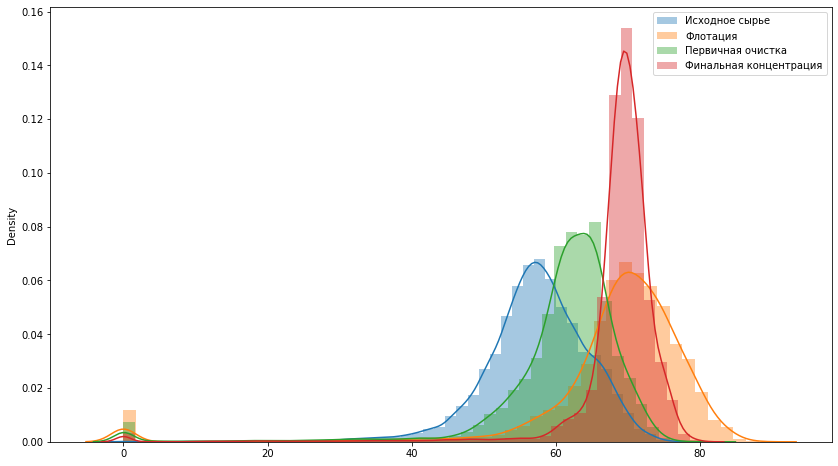

In [32]:
plt.figure(figsize=(14,8))
sns.distplot(sum_feed, label='Исходное сырье')
sns.distplot(sum_rougher, label='Флотация')
sns.distplot(sum_primary, label='Первичная очистка')
sns.distplot(sum_final, label='Финальная концентрация')
plt.legend()
plt.show()

На гистограмме видно, что в сырье и черновом концентрате концентрация всех веществ практически не меняется, а вот в финальном концентрате концентрация всех веществ увеличивается практически вдвое.

Также на гистограмме видны выбросы в районе нуля на этапе флотации, первичной очистки и в финальной концентрации, но этих данных нет в обучающей и тестовой выборке, а в исходном сырье таких выбросов нет, поэтому эти выбросы никак не повлияют на наши модели. На всякий случай проверим это.

In [33]:
train_feed = (df_train['rougher.input.feed_ag'] +
              df_train['rougher.input.feed_pb'] +
              df_train['rougher.input.feed_sol'] +
              df_train['rougher.input.feed_au'])

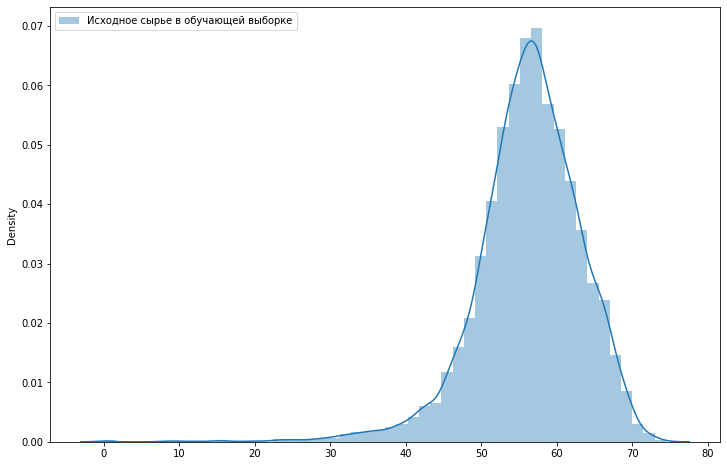

In [34]:
plt.figure(figsize=(12,8))
sns.distplot(train_feed, label='Исходное сырье в обучающей выборке')
plt.legend()
plt.show()

При проверке оказалось, что небольшие выбросы в районе нуля есть, поэтому отфильтруем их.

In [35]:
df_train = df_train[(df_train['rougher.input.feed_ag']>1)
                    &(df_train['rougher.input.feed_pb']>1)
                    &(df_train['rougher.input.feed_sol']>1)
                    &(df_train['rougher.input.feed_au']>1)]

In [36]:
test_feed = (df_test['rougher.input.feed_ag'] +
             df_test['rougher.input.feed_pb'] +
             df_test['rougher.input.feed_sol'] +
             df_test['rougher.input.feed_au'])

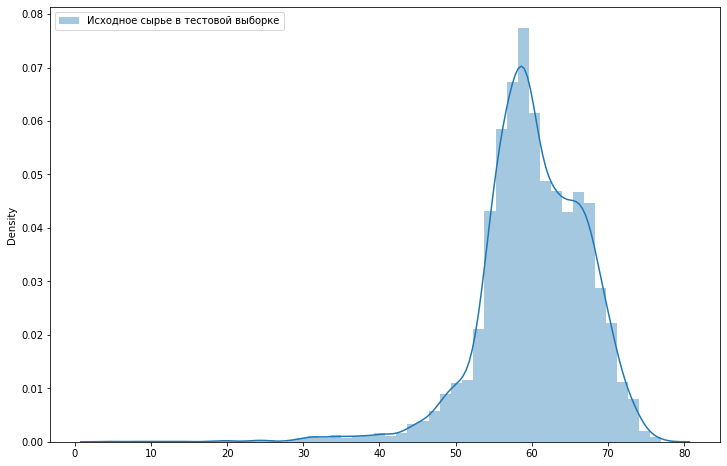

In [37]:
plt.figure(figsize=(12,8))
sns.distplot(test_feed, label='Исходное сырье в тестовой выборке')
plt.legend()
plt.show()

В тестовой выборке выбросов нет, поэтому оставляем ее так.

### Вывод по разделу

После анализа данных были сделаны следующие выводы:
1. После прохождения всех этапов очистки концентрация золота и свинца увеличивается, а концентрация серебра наоборот снижается.
2. Распределение размеров гранул сырья на обучающей и тестовой выборке похожи, поэтому модель будет работать правильно.
3. При исследовании суммарной концентрации всех веществ на разных стадиях: в сырье и черновом концентрате она практически не меняется, а вот в финальном концентрате концентрация всех веществ увеличивается практически вдвое.

## Модель

### sMAPE

Для решения задачи введём новую метрику качества — <b>sMAPE</b> (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Для задач регрессии чем меньше значение метрики, тем лучше.

In [38]:
#создадим функцию для расчета sMAPE
def smape (target, predictions):
    return 1/len(target)*sum(abs(target-predictions)/((abs(target)+abs(predictions))/2))*100

In [39]:
#создадим новую метрику для оценки качества модели
smape_score = make_scorer(smape)

In [40]:
def total_smape (smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [41]:
#создадим выборки с признаками и целевыми признаками(отдельно для флотации и отдельно для финального концентрата)
features_train = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1) # общие признаки для двух целевых признаков
target_rougher_train = df_train['rougher.output.recovery'] # целевой признак для этапа флотации
target_final_train = df_train['final.output.recovery'] # целевой признак для финальной концентрации

#### Дерево решений

In [42]:
def tree(features, target):
    best_tree = None
    best_depth = 0
    best_smape = 20
    for depth in range(1, 10):
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model.fit(features, target)
        smape_score_tree = cross_val_score(model,
                                           features,
                                           target,
                                           cv=5,
                                           scoring=smape_score,
                                           n_jobs=-1).mean()
        if smape_score_tree < best_smape:
            best_tree = model
            best_smape = smape_score_tree
            best_depth = depth
    print('Лучший результат sMAPE: {} с max_depth {}'
      .format(best_smape, best_depth))
    return best_tree, best_smape

In [43]:
#посмотрим на результаты модели дерева решений для этапа флотации
tree_rougher, tree_rougher_smape = tree(features_train, target_rougher_train)

Лучший результат sMAPE: 11.531455970056712 с max_depth 4


In [44]:
#посмотрим на результаты модели дерева решений на финальном этапе
tree_final, tree_final_smape = tree(features_train, target_final_train)

Лучший результат sMAPE: 10.312148747789308 с max_depth 2


In [45]:
#итоговое sMAPE дерева решений
tree_total_smape = total_smape(tree_rougher_smape, tree_final_smape)
print('Итоговое sMAPE для дерева решений:', tree_total_smape)

Итоговое sMAPE для дерева решений: 10.61697555335616


#### Случайный лес

In [46]:
def forest(features, target):
    best_forest = None
    best_est = 0
    best_depth = 0
    best_smape = 20
    for depth in range(1, 10):
        for est in range(1,10):
            model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features, target)
            smape_score_forest = cross_val_score(model,
                                                 features,
                                                 target,
                                                 cv=5,
                                                 scoring=smape_score,
                                                 n_jobs=-1).mean()
            if smape_score_forest < best_smape:
                best_forest = model
                best_smape = smape_score_forest
                best_depth = depth
                best_est = est
    print('Лучший результат sMAPE: {} с max_depth {} и n_estimators {}'
      .format(best_smape, best_depth, best_est))
    return (best_forest, best_smape)

In [47]:
#посмотрим на результаты модели случайного леса для этапа флотации
forest_rougher, forest_rougher_smape = forest(features_train, target_rougher_train)

Лучший результат sMAPE: 10.901806523121152 с max_depth 5 и n_estimators 6


In [48]:
#посмотрим на результаты модели случайного леса на финальном этапе
forest_final, forest_final_smape = forest(features_train, target_final_train)

Лучший результат sMAPE: 10.021508844838745 с max_depth 5 и n_estimators 7


In [49]:
#итоговое sMAPE по случайному лесу
forest_total_smape = total_smape(forest_rougher_smape, forest_final_smape)
print('Итоговое sMAPE для случайного леса:',forest_total_smape)

Итоговое sMAPE для случайного леса: 10.241583264409346


#### Линейная регрессия

In [50]:
def reg_model(features, target):
    regression_model = LinearRegression()
    regression_model.fit(features, target)
    smape_score_regression = cross_val_score(regression_model,
                                             features,
                                             target,
                                             cv=5,
                                             scoring=smape_score,
                                             n_jobs=-1).mean()
    print('Лучший результат sMAPE:', smape_score_regression)
    return (regression_model, smape_score_regression)

In [51]:
#посмотрим на результаты модели линейной регрессии для этапа флотации
regression_rougher, regression_rougher_smape = reg_model(features_train, target_rougher_train)

Лучший результат sMAPE: 12.774081397480504


In [52]:
#посмотрим на результаты модели линейной регрессии на финальном этапе
regression_final, regression_final_smape = reg_model(features_train, target_final_train)

Лучший результат sMAPE: 11.971313778991943


In [53]:
#итоговое sMAPE по линейной регрессии
regression_total_smape = total_smape(regression_rougher_smape, regression_final_smape)
print('Итоговое sMAPE для линейной регрессии:', regression_total_smape)

Итоговое sMAPE для линейной регрессии: 12.172005683614085


Лучший результат итогового sMAPE среди трех моделей продемонстрировал случайный лес с результатом 10.241. 

### Проверка модели на тестовой выборке

Итак, мы определили, что лучшей моделью у нас оказался случайный лес. Проверим результаты его работы на тестовой выборке.

In [54]:
#для начала подготовим тестовую выборку
features_test = df_test # общие признаки для двух целевых признаков

#целевые признаки возьмем из датасета full, т.к. в тестовой выборке их нет
target_rougher_test = df_full['rougher.output.recovery'][df_test.index] # целевой признак для этапа флотации
target_final_test = df_full['final.output.recovery'][df_test.index] # целевой признак для финальной концентрации

Будем использовать модели случайного леса с параметрами, показавшими лучший результат на обучающей выборке.

In [55]:
forest_model_rougher = RandomForestRegressor(random_state=12345, n_estimators=6, max_depth=5)
forest_model_rougher.fit(features_test, target_rougher_test)
smape_forest_model_rougher = cross_val_score(forest_model_rougher,
                                             features_test,
                                             target_rougher_test,
                                             cv=5,
                                             scoring=smape_score,
                                             n_jobs=-1).mean()
print('sMAPE случайного леса на тестовой выборке:', smape_forest_model_rougher)

sMAPE случайного леса на тестовой выборке: 12.098099816552534


In [56]:
forest_model_final = RandomForestRegressor(random_state=12345, n_estimators=7, max_depth=5)
forest_model_final.fit(features_test, target_final_test)
smape_forest_model_final = cross_val_score(forest_model_final,
                                             features_test,
                                             target_final_test,
                                             cv=5,
                                             scoring=smape_score,
                                             n_jobs=-1).mean()
print('sMAPE случайного леса на тестовой выборке:', smape_forest_model_final)

sMAPE случайного леса на тестовой выборке: 13.132207921468947


In [57]:
forest_total_test_smape = total_smape(smape_forest_model_rougher, smape_forest_model_final)
print('Итоговое sMAPE случайного леса на тестовой выборке:', forest_total_test_smape)

Итоговое sMAPE случайного леса на тестовой выборке: 12.873680895239843


Результат sMAPE получился хуже, чем на обучающей выборке - 12.873. Попробуем проверить показатель линейной регрессии на тестовой выборке.

In [58]:
#посмотрим на результаты тестовой выборки для этапа флотации
regression_test_rougher, regression_test_rougher_smape = reg_model(features_test, target_rougher_test)

Лучший результат sMAPE: 12.998592331737893


In [59]:
#посмотрим на результаты тестовой выборки на финальном этапе
regression_test_final, regression_test_final_smape = reg_model(features_test, target_final_test)

Лучший результат sMAPE: 10.417107059213853


In [60]:
regression_total_test_smape = total_smape(regression_test_rougher_smape, regression_test_final_smape)
print('Итоговое sMAPE на тестовой выборке:', regression_total_test_smape)

Итоговое sMAPE на тестовой выборке: 11.062478377344863


Итоговое sMAPE линейной регрессии на тестовой выборке составило 11.062. Результат хороший и лучше, чем у случайного леса, поэтому будем использовать линейную регрессию.

### Проверка модели на адекватность

Сравним нашу модель с константной моделью из DummyRegressor, которая предсказывает среднее значение от целевых значений, чтобы убедиться, что она работает адекватно.

In [61]:
#обучим dummy модель
dummy_rougher = DummyRegressor(strategy='mean')
dummy_rougher.fit(features_train, target_rougher_train)
dummy_rougher_predict = dummy_rougher.predict(features_test)

dummy_final = DummyRegressor(strategy='mean')
dummy_final.fit(features_train, target_final_train)
dummy_final_predict = dummy_rougher.predict(features_test)

In [62]:
#и проверим получившийся результат sMAPE
smape_dummy_rougher_test = smape(target_rougher_test, dummy_rougher_predict)
smape_dummy_final_test = smape(target_final_test, dummy_final_predict)

dummy_total_test_smape = total_smape(smape_dummy_rougher_test, smape_dummy_final_test)
print('Итоговый sMAPE Dummy модели составляет:', dummy_total_test_smape)

Итоговый sMAPE Dummy модели составляет: 17.854900797328266


Итоговый sMAPE Dummy модели составил 17.854, а это означает, что наша модель работает адекватно, т.к. итоговое sMAPE на ней составило 11.062.

### Вывод по разделу

1. Для решения задачи была введена новая метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
2. Было обучено 3 модели: дерево решений, случайный лес и линейная регрессия.
3. Были получены следующие результаты sMAPE по 3 моделям:
    1. Дерево решений - 10.616;
    2. Случайный лес - 10.241;
    3. Линейная регрессия - 12.172.
4. Лучшей по результатам проверки работы модели на тестовой выборке признана линейная регрессия и мы получили показатель sMAPE - 11.062, что является хорошим результатом.
5. Исходя из проверки, наша модель работает адекватно.

## Общий вывод

1. Эффективность обогащения в обучающей выборке рассчитана правильно, т.к. показатель МАЕ составил 9,73, что является хорошим . результатом и говорит о корректности расчетов.
2. В тестовой выборке на всех этапах отсутствуют выходные параметры продукта (output): концентрация металлов (concentrate) и отвальные хвосты (tail) для металлов (Au, Ag, Pb) и солей (Sol). Эти данные не подойдут для тренировки модели, так как появляются во время или после измерения целевых признаков. Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации - calculation. Данные колонки были удалены из обучающего датасета, а столбцы final.output.recovery и rougher.output.recovery были назначены целевыми признаками.
3. После прохождения всех этапов очистки концентрация золота и свинца увеличивается, а концентрация серебра наоборот снижается.
4. Распределение размеров гранул сырья на обучающей и тестовой выборке похожи, поэтому модель будет работать правильно.
5. При исследовании суммарной концентрации всех веществ на разных стадиях: в сырье и черновом концентрате она практически не меняется, а вот в финальном концентрате концентрация всех веществ увеличивается практически вдвое.
6. Для решения задачи была введена новая метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
7. Лучшей была признана линейная регрессия и по результатам проверки работы модели на тестовой выборке получили результат sMAPE - 11.062, что является хорошим результатом.